# Algorithmic Trading Model for Combo Moving Average Crossover Grid Search
### July 28, 2020


## Task 1. Prepare Environment

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [2]:
stock_symbol = 'NVDA'
initial_capital = 0

# Specify the moving average parameters for the trading strategy
fast_ema_min = 5
fast_ema_max = 20
slow_ema_min = 10
slow_ema_max = 50
fast_sma_min = 5
fast_sma_max = 20
slow_sma_min = 10
slow_sma_max = 50
ma_increment = 5
min_ma_gap = 5

# The number of extra days of data we need (usually equals to the larger of slow_ema or slow_sma)
extra_days_data = 50

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(extra_days_data*1.5)) # Need more pricing data to calculate moving averages

model_end_date = datetime.now()
# model_end_date = datetime(2020, 6, 30)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-07-29 02:13:34.890593


In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_models = False
verbose_graphs = False
verbose_portfolios = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = True
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

## Task 2. Acquire and Pre-Process Data

In [4]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [5]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [6]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')

446 data points retrieved from the API call.


In [7]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending=True)
stock_quandl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 446 entries, 2018-10-18 to 2020-07-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       446 non-null    object 
 1   date         446 non-null    object 
 2   open         446 non-null    float64
 3   high         446 non-null    float64
 4   low          446 non-null    float64
 5   close        446 non-null    float64
 6   volume       446 non-null    float64
 7   dividend     446 non-null    float64
 8   closeunadj   446 non-null    float64
 9   lastupdated  446 non-null    object 
dtypes: float64(7), object(3)
memory usage: 38.3+ KB


In [8]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2018-10-18,NVDA,2018-10-18,245.86,247.41,237.09,239.53,13100548.0,0.0,239.53,2020-05-01
2018-10-19,NVDA,2018-10-19,241.76,242.55,227.70,229.17,15340249.0,0.0,229.17,2020-05-01
2018-10-22,NVDA,2018-10-22,231.28,235.32,227.07,231.22,9221091.0,0.0,231.22,2020-05-01
2018-10-23,NVDA,2018-10-23,220.43,224.19,216.71,221.06,15660945.0,0.0,221.06,2020-05-01
2018-10-24,NVDA,2018-10-24,219.51,221.39,198.85,199.41,22107199.0,0.0,199.41,2020-05-01


In [9]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-07-22,NVDA,2020-07-22,414.70,424.10,411.662,417.55,9092161.0,0.0,417.55,2020-07-22
2020-07-23,NVDA,2020-07-23,418.71,421.88,401.250,405.19,10291532.0,0.0,405.19,2020-07-23
2020-07-24,NVDA,2020-07-24,395.00,414.59,391.080,407.78,11832300.0,0.0,407.78,2020-07-24
2020-07-27,NVDA,2020-07-27,409.29,417.67,408.710,416.86,7078129.0,0.0,416.86,2020-07-27
2020-07-28,NVDA,2020-07-28,414.97,415.28,408.370,408.62,6688009.0,0.0,408.62,2020-07-28


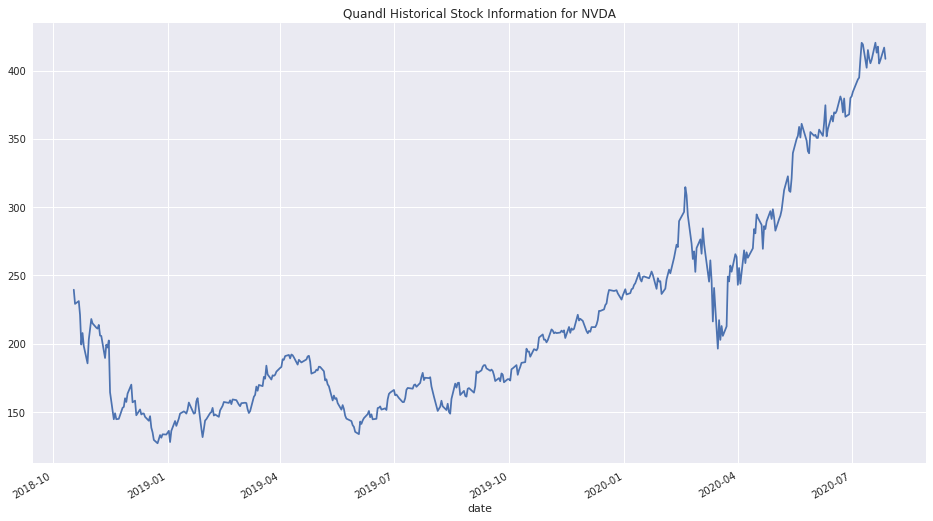

In [10]:
quandl_title = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=quandl_title)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [11]:
# Set up the standard column name for modeling
model_template = stock_quandl.loc[:, ['open','close']]
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
model_template.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 446 entries, 2018-10-18 to 2020-07-28
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   446 non-null    float64
 1   close_price  446 non-null    float64
dtypes: float64(2)
memory usage: 10.5 KB


### 3.b) Set up the Analysis Table with Indicators

In [12]:
# Define the functions that will generate the trading signals based on the different MA curves used

def ema_only_crossover(model):
    wait_for_entry = True
    for x in range(len(model)):
        if model['ema_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should enter into a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should exit the long position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if wait_for_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

def sma_only_crossover(model):
    wait_for_entry = True
    for x in range(len(model)):
        if model['sma_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should enter into a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should exit the long position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if wait_for_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

In [13]:
# Processing models using only the EMA curves
ema_model_collection = {}
serial_number = 1
for slow_ma in range(slow_ema_min, slow_ema_max+1, ma_increment):
    for fast_ma in range(fast_ema_min, fast_ema_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing EMA model with slow_ema of', slow_ma, 'and fast_ema of', fast_ma)
        model_tag = 'EMA_' + str(serial_number).zfill(3) + '_SlowEMA_' + str(slow_ma).zfill(3) + '_FastEMA_' + str(fast_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ema'] = trading_model['close_price'].ewm(span=fast_ma).mean()
        trading_model['slow_ema'] = trading_model['close_price'].ewm(span=slow_ma).mean()
        trading_model['ema_change'] = trading_model['fast_ema'] - trading_model['slow_ema']
        trading_model['fast_sma'] = trading_model['close_price'].rolling(fast_ma).mean()
        trading_model['slow_sma'] = trading_model['close_price'].rolling(slow_ma).mean()
        trading_model['sma_change'] = trading_model['fast_sma'] - trading_model['slow_sma']
        trading_model['fastema_slowsma_chg'] = trading_model['fast_ema'] - trading_model['slow_sma']
        trading_model['fastsma_slowema_chg'] = trading_model['fast_sma'] - trading_model['slow_ema']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        ema_only_crossover(trading_model)
        ema_model_collection[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(serial_number-1, 'EMA only models generated!')

# Processing models using only the SMA curves
print()
sma_model_collection = {}
serial_number = 1
for slow_ma in range(slow_sma_min, slow_sma_max+1, ma_increment):
    for fast_ma in range(fast_sma_min, fast_sma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing EMA model with slow_ema of', slow_ma, 'and fast_ema of', fast_ma)
        model_tag = 'SMA_' + str(serial_number).zfill(3) + '_SlowSMA_' + str(slow_ma).zfill(3) + '_FastSMA_' + str(fast_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ema'] = trading_model['close_price'].ewm(span=fast_ma).mean()
        trading_model['slow_ema'] = trading_model['close_price'].ewm(span=slow_ma).mean()
        trading_model['ema_change'] = trading_model['fast_ema'] - trading_model['slow_ema']
        trading_model['fast_sma'] = trading_model['close_price'].rolling(fast_ma).mean()
        trading_model['slow_sma'] = trading_model['close_price'].rolling(slow_ma).mean()
        trading_model['sma_change'] = trading_model['fast_sma'] - trading_model['slow_sma']
        trading_model['fastema_slowsma_chg'] = trading_model['fast_ema'] - trading_model['slow_sma']
        trading_model['fastsma_slowema_chg'] = trading_model['fast_sma'] - trading_model['slow_ema']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        sma_only_crossover(trading_model)
        sma_model_collection[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(serial_number-1, 'SMA only models generated!')

30 EMA only models generated!

30 SMA only models generated!


In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(model_collection):
    for model_name in model_collection:
        print('List the signal change and entry/exit points for', model_name)
        print(model_collection[model_name][(model_collection[model_name].signal_change != 0) | (model_collection[model_name].entry_exit != 0)])
        print()

In [15]:
if verbose_models: list_model_entry_exit(ema_model_collection)

In [16]:
if verbose_models: list_model_entry_exit(sma_model_collection)

In [17]:
def draw_model_graphs(model_name, trade_model, fast_ma_curve='fast_ema', slow_ma_curve='slow_ema'):
    graph_data = trade_model.copy()
    title_string = "Moving Average Crossover Model for " + model_name
    fig = plt.figure(figsize=(16,9))
    ylabel = stock_symbol + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data[fast_ma_curve].plot(ax=ax1, color='b', lw=2.)
    graph_data[slow_ma_curve].plot(ax=ax1, color='r', lw=2.)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

In [18]:
if verbose_graphs:
    for tag in ema_model_collection:
        draw_model_graphs(tag, ema_model_collection[tag], 'fast_ema', 'slow_ema')

In [19]:
if verbose_graphs:
    for tag in sma_model_collection:
        draw_model_graphs(tag, sma_model_collection[tag], 'fast_sma', 'slow_sma')

## Task 4. Back-test Model

In [20]:
def trading_portfolio_generation(initial_fund, trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [21]:
def generate_portfolio_and_performance(model_collection):
    # Initialize a dictionary for tracking portfolios for all models
    portfolio_collection = {}
    # Initialize a dataframe for reporting model performance summary
    performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

    for model_name in model_collection:
        if verbose_portfolios: print('Processing portfolio for model:', model_name)
        portfolio_collection[model_name] = trading_portfolio_generation(initial_capital, model_collection[model_name])
        trade_transactions = portfolio_collection[model_name][portfolio_collection[model_name].trade_action != 0]
        if verbose_portfolios: print(trade_transactions)
        if verbose_portfolios: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[model_name].accumu_return[-1]))
        if initial_capital != 0:
            return_percentage = portfolio_collection[model_name].accumu_return[-1] / initial_capital * 100
            if verbose_portfolios: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
        else:
            return_percentage = None
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            if verbose_portfolios: print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
        else:
            if verbose_portfolios: print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
        performance_summary = performance_summary.append({'model_name': model_name, 'return_value': portfolio_collection[model_name].accumu_return[-1], 'return_percent': return_percentage}, ignore_index=True)
    performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
    return portfolio_collection, performance_summary

In [22]:
ema_portfolio_collection, ema_performance_summary = generate_portfolio_and_performance(ema_model_collection)
print(len(ema_portfolio_collection), 'trading transaction portfolios generated.')
print(len(ema_performance_summary), 'profit/loss performance summaries generated.')

30 trading transaction portfolios generated.
30 profit/loss performance summaries generated.


In [23]:
sma_portfolio_collection, sma_performance_summary = generate_portfolio_and_performance(sma_model_collection)
print(len(sma_portfolio_collection), 'trading transaction portfolios generated.')
print(len(sma_performance_summary), 'profit/loss performance summaries generated.')

30 trading transaction portfolios generated.
30 profit/loss performance summaries generated.


In [24]:
# Display the top models from EMA-only performance summary
print(ema_performance_summary.head())

                         model_name  return_value return_percent
4   EMA_005_SlowEMA_020_FastEMA_010       251.020           None
6   EMA_007_SlowEMA_025_FastEMA_005       229.520           None
7   EMA_008_SlowEMA_025_FastEMA_010       225.807           None
2   EMA_003_SlowEMA_015_FastEMA_010       222.380           None
10  EMA_011_SlowEMA_030_FastEMA_005       212.422           None


In [25]:
# Display the top models from SMA-only performance summary
print(sma_performance_summary.head())

                         model_name  return_value return_percent
11  SMA_012_SlowSMA_030_FastSMA_010       277.975           None
10  SMA_011_SlowSMA_030_FastSMA_005       270.035           None
4   SMA_005_SlowSMA_020_FastSMA_010       255.300           None
3   SMA_004_SlowSMA_020_FastSMA_005       240.452           None
7   SMA_008_SlowSMA_025_FastSMA_010       238.440           None


In [26]:
# Display the entry/exit signals and transactions from the top model
def display_signals_transactions(model_name, portfolio_collection, model_collection):
    cols_to_display = ['open_price','close_price','fast_ema','slow_ema','fast_sma','slow_sma','trade_signal','signal_change','entry_exit']
    print('The transactions from the top model %s:' % model_name)
    print(portfolio_collection[model_name][portfolio_collection[model_name].trade_action != 0])
    print()
    print('The trading signal changes from the top model %s:' % model_name)
    print(model_collection[model_name][(model_collection[model_name].signal_change != 0) | (model_collection[model_name].entry_exit != 0)][cols_to_display])

The transactions from the top model SMA_012_SlowSMA_030_FastSMA_010:
           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-01-17            1          1     147.51                0         0     -147.51         151.72           4.21          4.21
2019-02-11           -1          0          0           146.39     -1.12       -1.12              0          -1.12         -1.12
2019-02-12            1          1        148                0         0     -149.12         151.17           2.05          2.05
2019-05-03           -1          0          0           183.53     35.53       34.41              0          34.41         34.41
2019-06-24            1          1     152.62                0         0     -118.21         152.66          34.45         34.45
2019-08-08           -1     

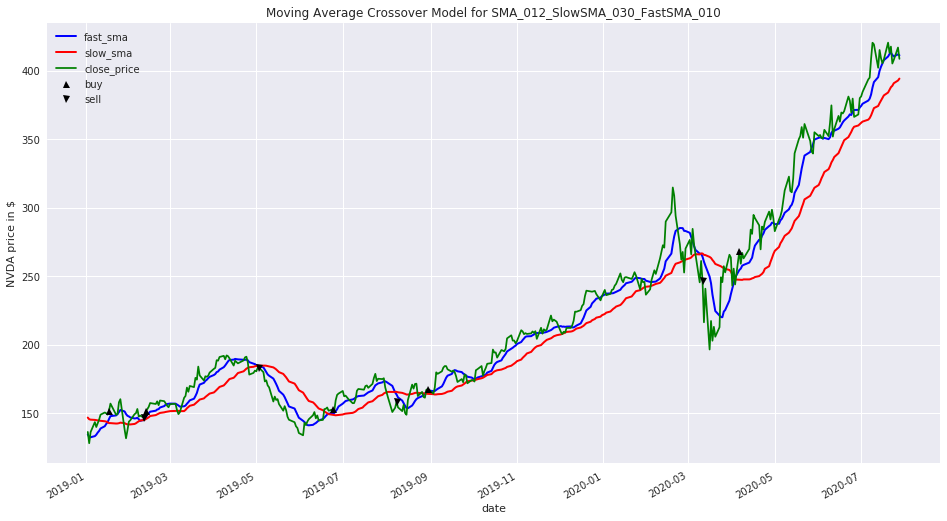

In [27]:
# Display the details for the top model
if ema_performance_summary.iloc[0]['return_value'] > sma_performance_summary.iloc[0]['return_value']:
    top_model = ema_performance_summary.iloc[0]['model_name']
    best_return = ema_performance_summary.iloc[0]['return_value']
    display_signals_transactions(top_model, ema_portfolio_collection, ema_model_collection)
    print()
    draw_model_graphs(top_model, ema_model_collection[top_model], 'fast_ema', 'slow_ema')
else:
    top_model = sma_performance_summary.iloc[0]['model_name']
    best_return = sma_performance_summary.iloc[0]['return_value']
    display_signals_transactions(top_model, sma_portfolio_collection, sma_model_collection)
    print()
    draw_model_graphs(top_model, sma_model_collection[top_model], 'fast_sma', 'slow_sma')

## Task 5. Evaluate Performance

In [28]:
print('The best model found is:', top_model)
print('The best profit/loss for the investing period is: $%.2f' % best_return)
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (best_return / initial_capital * 100))

The best model found is: SMA_012_SlowSMA_030_FastSMA_010
The best profit/loss for the investing period is: $277.98


In [29]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $277.98


In [30]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:02:39.977474
